# Final Project

**Due date: Saturday, December 9th**

For your final project you will develop a data narrative with a dataset of your choosing. Your data can come from any source. You do not have to comprehensively explore your data. Pick an interesting aspect or two from which to build your narrative.

## Requirements

- At least **three** visualizations. Visualizations can be simple bar charts that total data categories or rich exploratory figures. (*Tables also count as visualizations but you must have at least two charts.*) 
- All of the code should be recorded in your narrative. That is, I should be able to run your notebook code start to finish re-producing each of your outputs without error.
- At least **two** but no more than **three** paragraphs walking the reader through your analysis.
- Charts should exhibit your command of `ggplot2/dplyr/forcats/tidyr` with: 
  - sensibly sorted categories, 
  - interpretable labels/axis titles, 
  - useful annotations (when applicable), 
  - adjustments to default chart aesthetics, 
  - appropriate markings (e.g. `geoms`) and encodings.

## Notes

*This project should not take you longer than the time to complete two of our assignments. It is meant to demonstrate that you can build an analysis using `R` and the `Tidyverse` from scratch. Focus your analysis on a small number of data features that you find interesting.*

*Remember all the ways of visualizing distributions (ECDFs, histograms, jitter-ed scatter plots, etc.). These will come in very handy!* 

In [1]:
library('tidyverse')
library('ggrepel')

Warning message:
“Failed to locate timezone database”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
df_movies = read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-03-09/movies.csv')

df_movies |> colnames()

Rows: 1794 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (24): imdb, title, test, clean_test, binary, domgross, intgross, code, d...
dbl  (7): year, budget, budget_2013, period_code, decade_code, metascore, im...
num  (1): imdb_votes
lgl  (2): response, error

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "year"          "imdb"          "title"         "test"         
 [5] "clean_test"    "binary"        "budget"        "domgross"     
 [9] "intgross"      "code"          "budget_2013"   "domgross_2013"
[13] "intgross_2013" "period_code"   "decade_code"   "imdb_id"      
[17] "plot"          "rated"         "response"      "language"     
[21] "country"       "writer"        "metascore"     "imdb_rating"  
[25] "director"      "released"      "actors"        "genre"        
[29] "awards"        "runtime"       "type"          "poster"       
[33] "imdb_votes"    "error"

The [Bechdel test](https://en.wikipedia.org/wiki/Bechdel_test) is used to assess the representation of women in a given work of fiction. A work passes the Bechdel test if it has at least two named women who talk to each other about something besides a man and fails otherwise. We will now analyze a dataset of movies released between 1970 and 2013 to explore trends related to female representation in film. Fist we will plot the top 5 rated movies that pass and fail the Bechdel test to provide some examples of each category.

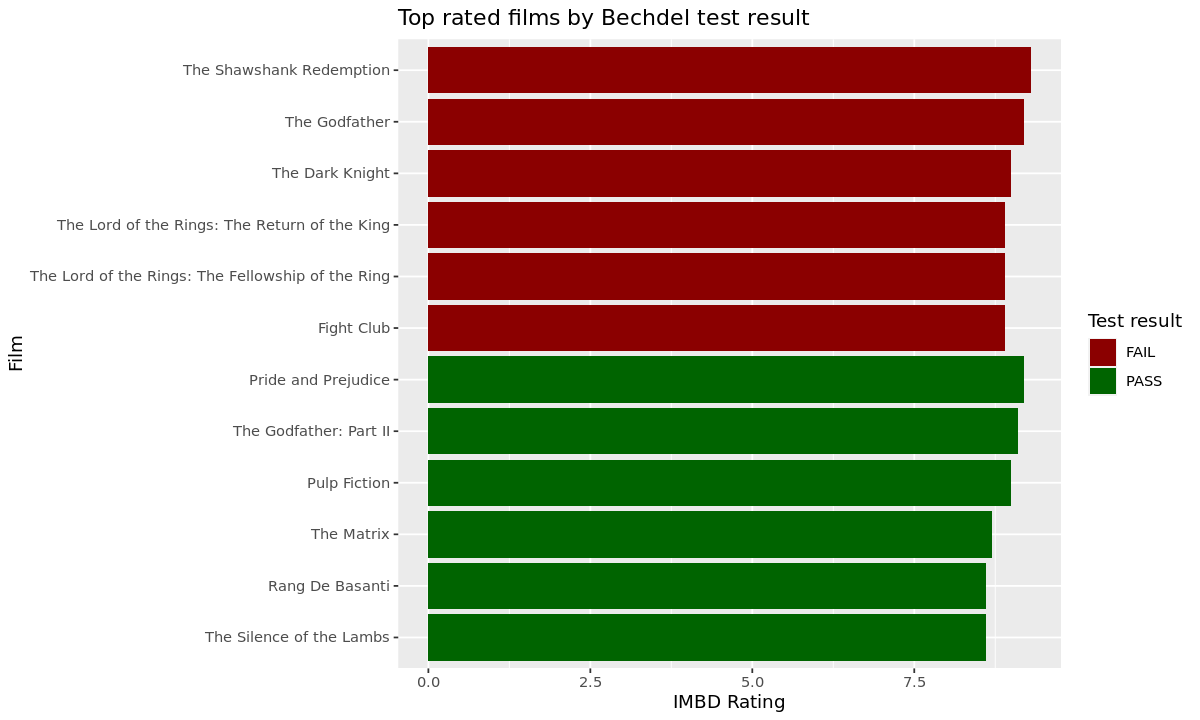

In [3]:
options(repr.plot.height = 6, repr.plot.width = 10, resolution = 300)

# plot the top 5 movies passing and failing the Bechdel test
df_movies_top = df_movies |>
    group_by(binary) |>
    arrange(imdb_rating) |>
    slice_max(n = 5, order_by = imdb_rating) |>
    ungroup() |>
    mutate(title = as.factor(title) |> fct_inorder() |> fct_rev())

p = ggplot(df_movies_top, aes(y = title, weight = imdb_rating, fill = binary)) +
    geom_bar() +
    scale_fill_manual(values = c('darkred', 'darkgreen'), name = 'Test result') +
    labs(x = 'IMBD Rating', y = 'Film', title = 'Top rated films by Bechdel test result')

p

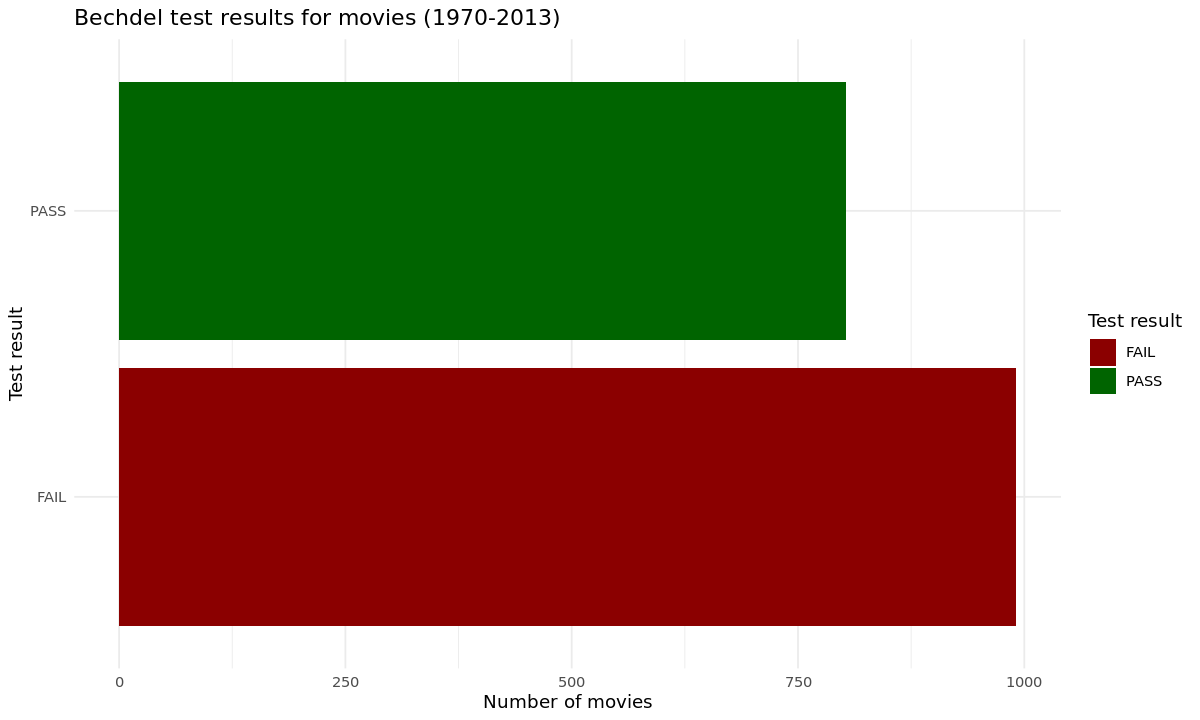

In [4]:
# plot the total number of movies passing and failing the Bechdel test between 1970 and 2013
p = ggplot(df_movies, aes(y = binary, fill = binary)) +
    geom_bar() +
    theme_minimal() +
    labs(x = 'Number of movies', y = 'Test result', title = 'Bechdel test results for movies (1970-2013)') +
    scale_fill_manual(values = c('darkred', 'darkgreen'), name = 'Test result')

p

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


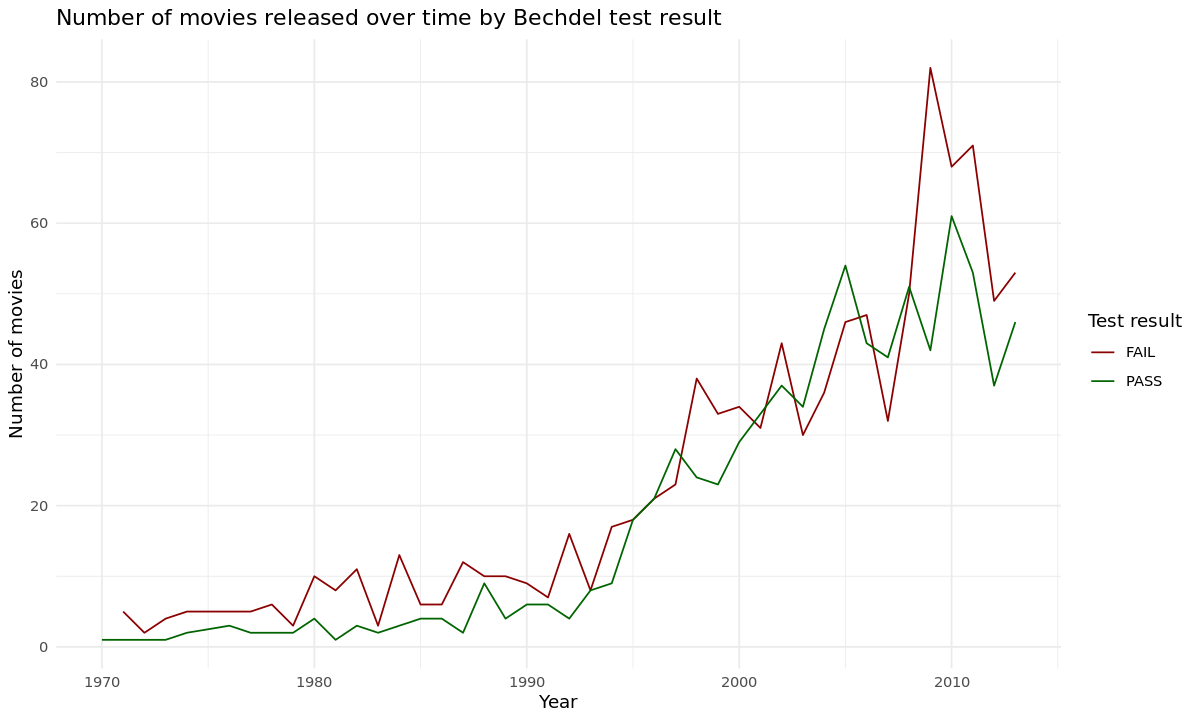

In [5]:
# plot the number of movies passing and failing the Bechdel test over time
df_movies_over_time = df_movies |>
    group_by(year, binary) |>
    summarize(number = n())

p = ggplot(df_movies_over_time, aes(x = year, y = number, color = binary)) +
    geom_line() +
    theme_minimal() +
    labs(x = 'Year', y = 'Number of movies', title = 'Number of movies released over time by Bechdel test result') +
    scale_color_manual(values = c('darkred', 'darkgreen'), name = 'Test result')

p

The line chart above shows that the number of movies passing and failing the Bechdel test has steadily increased over time. To make clear the how the proportion of movies passing the Bechdel test over time has changed, we will constuct a chart showing how the percentage of movies passing the Bechdel test in a given year has changed over time. As a reference point, we will add a feature indicating the average pass rate over the whole dataset.

In [6]:
# calculate pass rates by year
df_movies_yearly_total = df_movies |>
    group_by(year) |>
    summarize(number = n())

df_movies_yearly_pass = df_movies |>
    filter(binary == 'PASS') |>
    group_by(year) |>
    summarize(number_pass = n())

df_pass_rate = full_join(df_movies_yearly_total, df_movies_yearly_pass) |>
    mutate_if(is.numeric, replace_na, 0) |>
    mutate(pass_rate = number_pass / number)

# Display the total pass rate between 1970 and 2013
df_pass_rate_total = df_pass_rate |> summarize(pass_rate = sum(number_pass) / sum(number))

df_pass_rate_total

Joining with `by = join_by(year)`


pass_rate
<dbl>
0.4476031


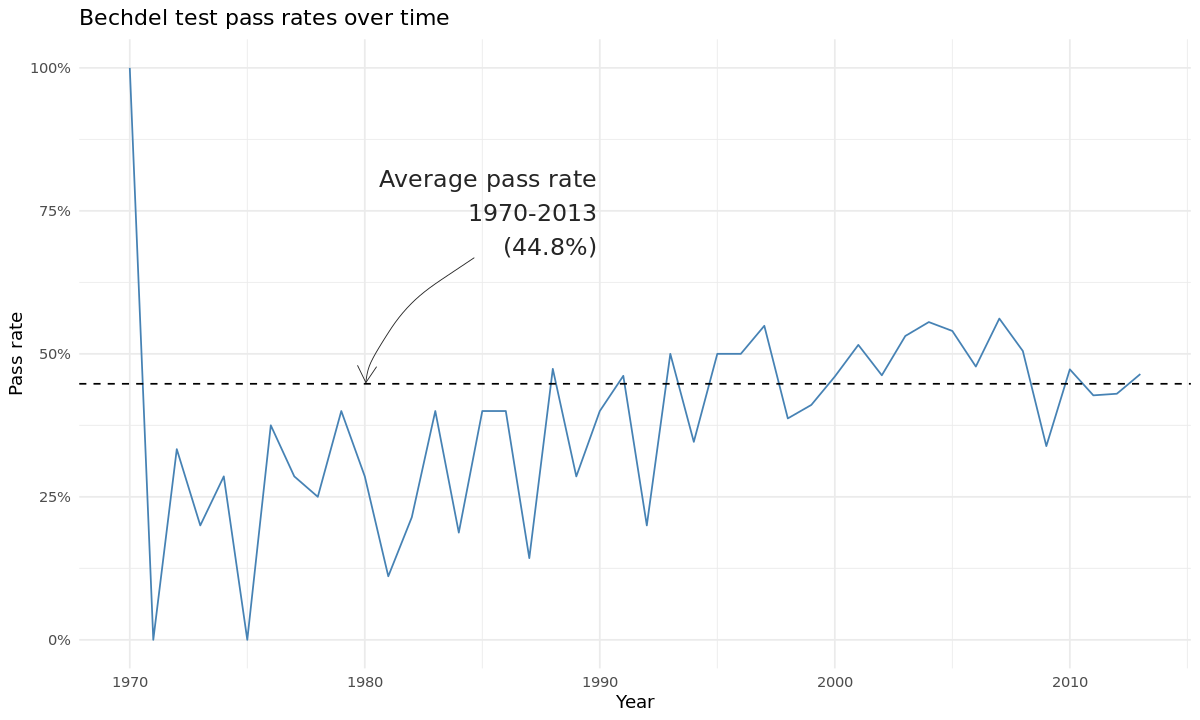

In [7]:
# plot the yearly Bechdel test pass rate over time
df_pass_rate_label = data.frame(xpos = c(1980), ypos = c(0.4476031), text = c('Average pass rate\n 1970-2013\n (44.8%)'))

p = ggplot(df_pass_rate, aes(x = year, y = pass_rate)) +
    geom_line(color = 'steelblue') +
    geom_hline(data = df_pass_rate_total, mapping = aes(yintercept = pass_rate), linetype = "dashed", color = "black") +
    theme_minimal() +
    scale_y_continuous(labels = scales::percent_format(scale = 100)) +
    labs(x = 'Year', y = 'Pass rate', title = 'Bechdel test pass rates over time') +
    geom_text_repel(data = df_pass_rate_label, mapping = aes(x = xpos, y = ypos, label = text), color = '#252525', size = 5,
                    segment.curvature = .2, segment.angle = 90, segment.alpha = 1,
                    nudge_x = 10, nudge_y = 0.3, segment.size = 0.25,
                    arrow = arrow(length = unit(0.03, "npc")), hjust = 1)

p

It looks like the proportion of films passing the Bechdel test has been increasing over time, indicating an increase in female representation in film. Now I want to see if there is a difference in the domestic gross earnings of movies that pass the Bechdel test vs. movies that fail the Bechdel test.

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `domgross_2013 = as.numeric(domgross_2013)/1e+06`.
Caused by warning:
! NAs introduced by coercion”


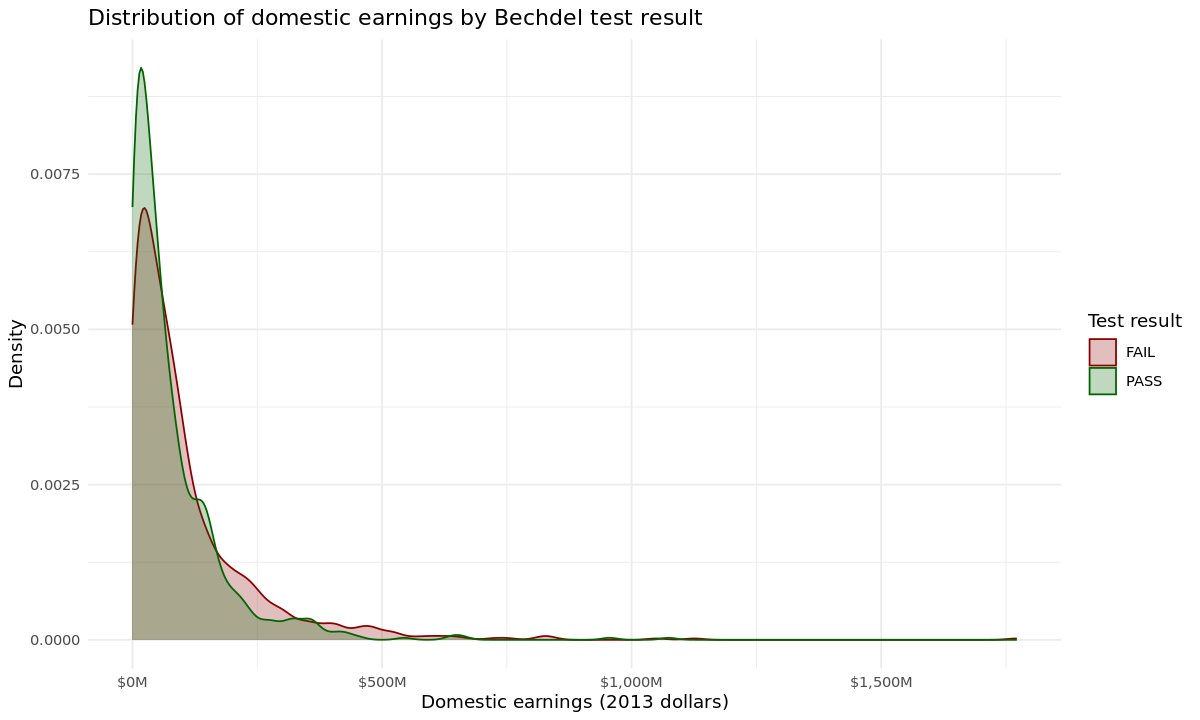

In [8]:
# convert the domgross_2013 column to numeric values and scale values to represent number of millions grossed
df_movies2 = df_movies |> mutate(domgross_2013 = as.numeric(domgross_2013) / 1e6)

# plot the distributions of domestic earnings for movies grouped by Bechdel test result
p = ggplot(df_movies2, aes(x = domgross_2013, color = binary, fill = binary)) + geom_density(alpha = 0.25, na.rm = T) +
    theme_minimal() +
    labs(title = 'Distribution of domestic earnings by Bechdel test result', y = 'Density', x = 'Domestic earnings (2013 dollars)') +
    scale_color_manual(values = c('darkred', 'darkgreen'), name = 'Test result') +
    scale_fill_manual(values = c('darkred', 'darkgreen'), name = 'Test result') +
    scale_x_continuous(labels = scales::dollar_format(suffix = 'M'))

p